In [5]:
# importing libraries

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns
import re

from nltk import bigrams, trigrams, word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from textblob import TextBlob

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle 
from sklearn.decomposition import TruncatedSVD
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Download Lexicons and Stopwords
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [7]:
# Reading the data
tweet_data = pd.read_csv('/Users/pasapulagnanasurya/Downloads/tweets_v8.csv')
tweet_data.shape

(80019, 12)

In [8]:
tweet_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
0,the _ûndër-ratèd niggáh👊🏾,NaN,@ManUtd die hard❤️❤️💪🏿💪🏿\n\n\nYOLO\n\n\nJ'ai b...,2019-09-06 19:24:57+00:00,581,1035,8922,False,2021-10-06 12:05:38+00:00,When life hits and the same time poverty strik...,Twitter for Android,False
1,Best uncle on planet earth,NaN,NaN,2013-05-08 19:35:26+00:00,741,730,8432,False,2021-10-06 12:05:22+00:00,That marble episode of #SquidGame ruined me. 😭😭😭,Twitter for Android,False
2,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False
3,YoMo.Mdp,Any pronouns,Where the heck is the karma\nI'm going on my s...,2021-02-14 13:21:22+00:00,3,277,1341,False,2021-10-06 12:05:04+00:00,//Blood on 1st slide\nI'm joining the squidgam...,Twitter Web App,False
4,Laura Reactions,France,I talk and I make reactions videos about shows...,2018-12-19 20:38:28+00:00,330,152,2278,False,2021-10-06 12:05:00+00:00,"The two first games, players were killed by th...",Twitter Web App,False


In [9]:
# get only required columns
data = tweet_data[['user_location','date','text','source','user_verified','is_retweet']]

In [10]:
# missing value check
data.isnull().sum()

user_location    23870
date                 0
text                 0
source               0
user_verified        0
is_retweet           0
dtype: int64

# Exploratory Analysis

In [11]:
stop_words=stopwords.words('english')
stop_words.extend(['squid','game'])

def clean_tweet(text,full_clean=False):
    le = WordNetLemmatizer()
    if type(text) == np.float64:
        return ""
    text = re.sub("'", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[()!?]', ' ', text)
    if full_clean:
      text = text.lower()
      text = re.sub("[^a-z0-9]"," ", text)
      text = [le.lemmatize(w) for w in text.split() if not (w in stop_words) and (len(w)>2)]
    else:
      text = re.sub("[^A-Za-z0-9]"," ", text)
      text = [le.lemmatize(w) for w in text.split() if (len(w)>2)]
    text = " ".join(word for word in text)
    return text


def word_cloud_gen(text,stop_words):
    plt.figure(figsize=(20,10))
    wordcloud = WordCloud(width=800,height=400,stopwords=stop_words, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    # return wordcloud.words_

In [ ]:
data['full_clean'] = data['text'].apply(lambda x : clean_tweet(x,full_clean=True))

In [14]:
all_tweets = " ".join(data['full_clean'])
bigms = bigrams(word_tokenize(all_tweets))
fdist = FreqDist(bigms)
sorted_fdist = dict(sorted(fdist.items(), key=lambda item: item[1],reverse=True))

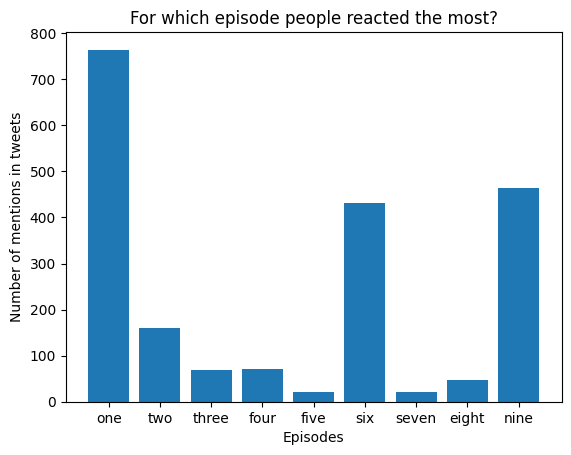

In [15]:
# Most mentioned episodes
six_ = ['marble','gganbu','6','6th','six','sixth','ganbu']
one_ = ['one','1','1st','light','first']
two_ = ['second','2nd','two','2','hell']
three_ = ['three','3','3rd','third','umbrella','honeycomb','daglona']
four_ = ['four','4','4th','fourth','war','tug']
five_ = ['five','5th','5','fifth']
seven_ = ['vip','seven','7','7th','seventh','vips']
eight_ = ['eight','eighth','8','8th','man']
nine_ = ['nine','9','9th','ninth','final','last','day']

episodes = {'one':0,
            'two':0,
            'three':0,
            'four':0,
            'five':0,
            'six':0,
            'seven':0,
            'eight':0,
            'nine':0}

for k,v in sorted_fdist.items():
  if 'episode' in k:
    if k[0] in one_ or k[1] in one_:
      episodes['one'] += int(v)
    if k[0] in two_ or k[1] in two_:
      episodes['two'] += int(v)
    if k[0] in three_ or k[1] in three_:
      episodes['three'] += int(v)
    if k[0] in four_ or k[1] in four_:
      episodes['four'] += int(v)
    if k[0] in five_ or k[1] in five_:
          episodes['five'] += int(v)
    if k[0] in six_ or k[1] in six_:
      episodes['six'] += int(v)
    if k[0] in seven_ or k[1] in seven_:
      episodes['seven'] += int(v)
    if k[0] in eight_ or k[1] in eight_:
      episodes['eight'] += int(v)
    if k[0] in nine_ or k[1] in nine_:
      episodes['nine'] += int(v)     

plt.bar(range(len(episodes)), list(episodes.values()), align='center')
plt.xticks(range(len(episodes)), list(episodes.keys()))
plt.xlabel('Episodes')
plt.ylabel('Number of mentions in tweets')
plt.title('For which episode people reacted the most?')
plt.show()

In [16]:
# Most mentioned players
# https://www.marieclaire.com/culture/a37695414/squid-game-cast-netflix/

print("Players\t\tMentions")
for k,v in sorted_fdist.items():
  if 'player' in k and (k[0].isnumeric() or k[1].isnumeric()) and v >= 15:
    print(f"{' '.join(k)}\t{v}")

Players		Mentions
player 001	143
player 067	137
player 456	136
player 199	46
player 218	45
player 212	38
player 240	24
456 player	19
player 101	15


In [17]:
# Tri grams
trigms = trigrams(word_tokenize(all_tweets))
fdist_tri = FreqDist(trigms)
sorted_fdist_tri = dict(sorted(fdist_tri.items(), key=lambda item: item[1],reverse=True))

In [19]:
player_dict = {'001':[],'456':[],'067':[],'199':[],'218':[],'212':[],'240':[],'101':[]}

for p in player_dict.keys():
  for k,v in sorted_fdist_tri.items():
    if p in k:
      player_dict[p].extend(list(k))


# Sentiment Analysis

## Lexicon Sentiment Analysis - TextBlob and VADER

In [23]:
def textblob_sentiment(text):
        analysis = TextBlob(clean_tweet(text))
        if analysis.sentiment.polarity > 0:
            return "Positive"
        elif analysis.sentiment.polarity < 0:
            return "Negative"
        else:
            return "Neutral"

In [24]:
def sentiment_scores(text):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(clean_tweet(text))
    if sentiment_dict['compound'] >= 0.05 :
        return "Positive"
    elif sentiment_dict['compound'] <= -0.05 :
        return "Negative"
    else :
        return "Neutral"

In [25]:
I = 75234 #12334 #VADER IMP
# I = 1236 # NEGA
# I= 8564 #BAD
# I= 8536 #POS
data['text'][I]

'Just finished watching this ⭕\n"Circle" from Squid Game\n\n#artbyinyu #chibi #chibiart #SquidGame #squidgamefanart… https://t.co/06lbaZBiiH'

In [26]:
clean_tweet(data['text'][I])

'Just finished watching this Circle from Squid Game'

In [27]:
textblob_sentiment(clean_tweet(data['text'][I]))

'Negative'

In [28]:
sentiment_scores(clean_tweet(data['text'][I]))

'Neutral'

In [ ]:
data['TextBlob_Sentiment']=data['text'].apply(lambda x:textblob_sentiment(clean_tweet(x)))

In [ ]:
data['vader_Sentiment']=data['text'].apply(lambda x: sentiment_scores(clean_tweet(x)))

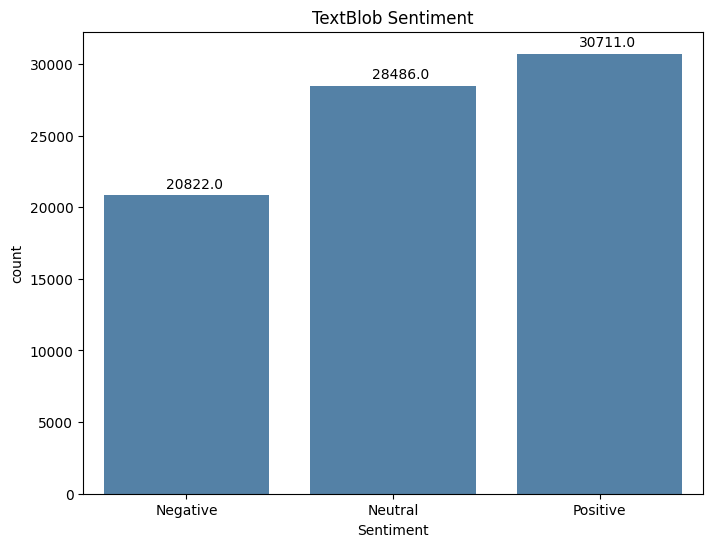

In [31]:
fig = plt.figure(figsize=(8,6))
ax = sns.countplot(x=data['TextBlob_Sentiment'],color='steelblue')
total = len(data['TextBlob_Sentiment'])
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 500
    ax.annotate(p.get_height(), (x, y), size = 10)
plt.xlabel('Sentiment')
plt.title('TextBlob Sentiment')
plt.show()

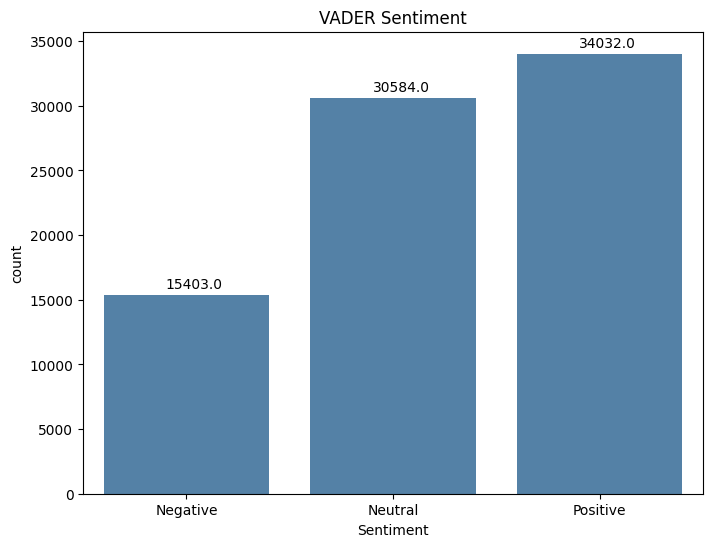

In [32]:
fig = plt.figure(figsize=(8,6))
ax = sns.countplot(x=data['vader_Sentiment'],color='steelblue')
total = len(data['vader_Sentiment'])
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 500
    ax.annotate(p.get_height(), (x, y), size = 10)
plt.xlabel('Sentiment')
plt.title('VADER Sentiment')
plt.show()

In [33]:
stop_word = stop_words[:]+['like','episode','watching','watched']

In [34]:
# Word Cloud Negative words
neg_ = data[data['TextBlob_Sentiment'] == 'Negative']['full_clean']
text = " ".join(neg_)
#word_cloud_gen(text,stop_word)

In [35]:
# Word Cloud positive words
pos_ = data[data['TextBlob_Sentiment'] == 'Positive']['full_clean']
text = " ".join(pos_)
#word_cloud_gen(text,stop_words)

## Machine Learning Approach

In [37]:
# get only the text and sentiment columns

labeled_data = data[['full_clean','vader_Sentiment']]
labedled_data = labeled_data[labeled_data['vader_Sentiment'] != 'Neutral']

In [38]:
def save_obj(path,obj):
  with open(path,'wb') as f:
    pickle.dump(obj,f)
  return path

def load_obj(path):
  with open(path,'rb') as f:
    return pickle.load(f)

In [39]:
labedled_data.head()

,full_clean,vader_Sentiment
0,life hit time poverty strike yougong yoo let play,Negative
1,marble episode ruined,Negative
3,blood 1st slideim joining squidgame thing alre...,Negative
4,two first game player killed mask guy bloody n...,Negative
6,pls use gun,Negative


In [40]:
train, val = train_test_split(labedled_data,test_size=0.2,random_state=213,stratify=labedled_data['vader_Sentiment'])

In [41]:
x_train = train['full_clean']
y_train = train['vader_Sentiment']

x_test = val['full_clean']
y_test = val['vader_Sentiment']


In [42]:
vectorizer = TfidfVectorizer(sublinear_tf = True,use_idf = True)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

In [43]:
train_vectors.shape

(39376, 19704)

In [44]:
# save_obj('train_vec.pkl',train_vectors)
# save_obj('test_vec.pkl',test_vectors)

In [45]:
# train_vectors = load_obj('train_vec.pkl')
# test_vectors = load_obj('test_vec.pkl')

In [46]:
svd_model = TruncatedSVD(n_components=8000)
svd_model.fit(train_vectors)
print("Sum of variance ratios: ",sum(svd_model.explained_variance_ratio_))

Sum of variance ratios:  0.9473032913484698


In [47]:
# save_obj('svd_model.pkl',svd_model)

In [48]:
# svd_model = load_obj('svd_model.pkl')

In [49]:
x_train_red = svd_model.transform(train_vectors)

In [50]:
x_test_red = svd_model.transform(test_vectors)

In [51]:
x_test_red.shape

(9845, 8000)

In [52]:
x_train_red.shape

(39376, 8000)

In [53]:
# save_obj('train_red.pkl',x_train_red)
# save_obj('test_red.pkl',x_test_red)
# save_obj('train_y.pkl',y_train)
# save_obj('test_y.pkl',y_test)

# x_train_red = load_obj('train_red.pkl')
# x_test_red = load_obj('test_red.pkl')
# y_train = load_obj('train_y.pkl')
# y_test = load_obj('test_y.pkl')


In [54]:
rf_model2 = RandomForestClassifier(n_estimators=700,random_state=213)
rf_model2.fit(x_train_red,y_train)
# save_obj('rf_model2.pkl',rf_model2)
# rf_model2 = load_obj('rf_model2.pkl')
predictions_rf = rf_model2.predict(x_test_red)

In [55]:
print("Random Forest Model")
print(classification_report(y_test,predictions_rf))

Random Forest Model
              precision    recall  f1-score   support

    Negative       0.97      0.25      0.40      3066
    Positive       0.75      1.00      0.85      6779

    accuracy                           0.76      9845
   macro avg       0.86      0.62      0.62      9845
weighted avg       0.82      0.76      0.71      9845



In [56]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=213)
SVM.fit(x_train_red,y_train)
# save_obj('svm_model.pkl',SVM)
# SVM = load_obj('svm_model.pkl')
predictions_SVM = SVM.predict(x_test_red)

In [57]:
print("SVM Model")
print(classification_report(y_test,predictions_SVM))

SVM Model
              precision    recall  f1-score   support

    Negative       0.92      0.86      0.89      3066
    Positive       0.94      0.97      0.95      6779

    accuracy                           0.93      9845
   macro avg       0.93      0.91      0.92      9845
weighted avg       0.93      0.93      0.93      9845

